# Forecasting Daily Ridership of the One Train

In [28]:
import pandas as pd
import numpy as np
import plotly.express as px
from sodapy import Socrata
import polars as pl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(100)
pl.Config.set_fmt_str_lengths(50)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option('display.max_colwidth', None)

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [29]:
mta_path = "MTA_Subway_Hourly_Ridership__2020-2024.csv"
columns_needed = ["transit_timestamp", "transit_mode", "station_complex_id", "station_complex", "borough", "payment_method", "fare_class_category","ridership", "transfers"]

# Polars Analysis and Data Collection

I use Polars to analyze and collect data as the dataset (13 GB) would be slow in Pandas. 

In [30]:
mta = pl.read_csv(mta_path, columns = columns_needed, ignore_errors=True)
mta = mta.with_columns(
    pl.col("transit_timestamp").str.strptime(pl.Datetime, "%m/%d/%Y %I:%M:%S %p")
)
mta.filter(pl.col("station_complex").str.contains(r"\(1\)")).select("station_complex").unique()

station_complex
str
"""157 St (1)"""
"""Canal St (1)"""
"""125 St (1)"""
"""23 St (1)"""
"""Cathedral Pkwy (110 St) (1)"""
"""Van Cortlandt Park-242 St (1)"""
"""Dyckman St (1)"""
"""66 St-Lincoln Center (1)"""
"""50 St (1)"""


Filtering the stations with the (1) train

In [31]:
one_train = (mta.filter(pl.col("station_complex").str.contains(r"\(1\)")))
one_train = one_train.with_columns(
    pl.col("transit_timestamp").dt.hour().alias("hour"),
    pl.col("transit_timestamp").dt.year().alias("year"),
    pl.col("transit_timestamp").dt.month().alias("month"),
    pl.col("transit_timestamp").dt.day().alias("day"),
    pl.col("transit_timestamp").cast(pl.Date).alias("date")

)
daily_df = one_train.group_by(['year', 'date']).agg(
    (pl.col("ridership").sum()).alias("daily_ridership")
)



Unfortunately, a lot of the open source data is missing, Also an important note of the methodology is that there is often a delay in when the transaction is made and when OMNI registers it, making daily prediction unfortunately unreliable.

In [32]:
daily_df = one_train.group_by(['year', 'date']).agg(
    (pl.col("ridership").sum()).alias("daily_ridership")
)

daily_df = daily_df.sort("year")
daily_df = daily_df.pivot("year", index = "date", values = "daily_ridership")
daily_df = daily_df.sort("date")
fig = px.line(daily_df, x = "date", y = daily_df.columns, title= "Daily Average Ridership of the One Train from 2020 to 2024")
fig.update_layout(hovermode = 'x unified')
fig.show()

In [33]:
daily_df = one_train.group_by(["date"]).agg(
    (pl.col("ridership").sum()).alias("daily_ridership")
)
daily_df= daily_df.sort("date")
daily_df = daily_df.to_pandas()

## Dealing with missing Data
We interpolate the data based on time. This would however increase the chance of errors

In [34]:

daily_df = daily_df.sort_values("date")
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_df.set_index("date", inplace = True)
daily_df.index = pd.to_datetime(daily_df.index)
freq = pd.infer_freq(daily_df.index)

if freq:
    complete_idx = pd.date_range(start = daily_df.index.min(), end = daily_df.index.max(), freq = freq)
else:
    complete_idx = pd.date_range(start = daily_df.index.min(), end = daily_df.index.max(), freq = 'D')

missing_idx = complete_idx.difference(daily_df.index)
print(f"Found {len(missing_idx)} missing time points")

daily_df = daily_df.reindex(complete_idx)
daily_df = daily_df.interpolate(method ="time")


Found 266 missing time points


To reduce the chances of errors, we take the data after feb 24, 2022

In [35]:
daily_df_test= daily_df.loc['2024-02-01':'2024-05-01']
daily_df = daily_df.loc['2022-02-24':'2024-01-31']

# Time Series Analysi

## Stationarity
A stationary time series has a constant mean and variance through time. Before using ARIMA we must check for a stationary time series.The time series we are using is clearly not stationary, the average number of people are increasing over time. The data also very clearly has seasonal trends, between weekdays and weekends. The variance is also not constant as over time the maximum and minimum are changing.

In [36]:
def adf(series):
    test_results = adfuller(series)
    print('ADF Statistic:', test_results[0])
    print('P Value:', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

In [37]:
adf(daily_df["daily_ridership"][1:])

ADF Statistic: -3.3064587157260052
P Value: 0.014592226665128731
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


### How to make a time series stationary ?
1. Making the mean constant
2. Making the variance constant

### Log Transform

In [38]:
def plot(df, y_col , title = "Daily Average Ridership of the One Train from 2020 to 2024" ):
    fig = px.line(df, x = df.index, y = y_col, title= title)
    #fig.update_layout(yaxis = dict(range = [0,200], dtick = 20))
    fig.show()

One way to make the variance stationary is by log transform: This assumes that the  data follows an exponential trend

In [39]:
daily_df["daily_ridership_log"] = np.log(daily_df["daily_ridership"])
plot(daily_df,  "daily_ridership_log")

The variance seems constant now but the mean is not : The most common way to make the mean constant is differencing, That is where the difference at the time t between the series at time y(t) and y(t-1)

In [40]:
daily_df["daily_ridership_diff"] = daily_df["daily_ridership_log"].diff()
plot(daily_df,  'daily_ridership_diff')

Stabilize the variance before stabilizing the mean! Why ?
Variance transformations like logarithmic or Box-Cox transformations are nonlinear and change both the variance and mean structures of the series. However, mean transformations (like differencing or detrending) generally don't affect the variance pattern.

### Box-Cox Transform
Another way to ensure stationarity for transform is thorough boxcox transform. The Box-Cox Transform changes Non Normal Distribution to Normal Distribution. Common models such as ARIMA assume that we are dealing with Box-Cox Transform. It is preffered over log transform, as it is more stable.

In [41]:
from scipy.stats import boxcox

daily_df["daily_ridership_box_cox"], lam = boxcox(daily_df["daily_ridership"])
plot(daily_df, y_col='daily_ridership_box_cox')

1. lam = 0 , exponential
2. lam = 1 , no transform
3. lam = 2 , square root transform
4. lam = 3 , cubic transform

In [42]:
daily_df["daily_ridership_box_cox_diff"] = daily_df["daily_ridership_box_cox"].diff()
plot(daily_df, y_col="daily_ridership_box_cox_diff")

Checking for stationarity

In [43]:
adf(daily_df["daily_ridership_box_cox_diff"][1:])

ADF Statistic: -8.95524592870455
P Value: 8.508891345711832e-15
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


## Seasonality

Generally, time series data repeats on a weekly, monthly and yearly basis


### Time Series Decomposition

A Time Series is composed of three main elements : Trend, Seasonality and Residual/Remainder
Additive Model :
Y = T + S + R
Multiplicative Model :
Y = T * S * R
We can also write it as :
ln(Y) = ln(T) + ln (S) + ln(R)

In an additive model the function of time series is either decreasing or increasing by a constant 
In a multiplicative model the function is increasing or decreasing by a variable 

The Classical Approach:
1. Compute the trend component
2. De-trend the series Y - T and Y/T
3. Compute the seasonal component S
4. Compute the residual component R

### Multiplicative Decomposition

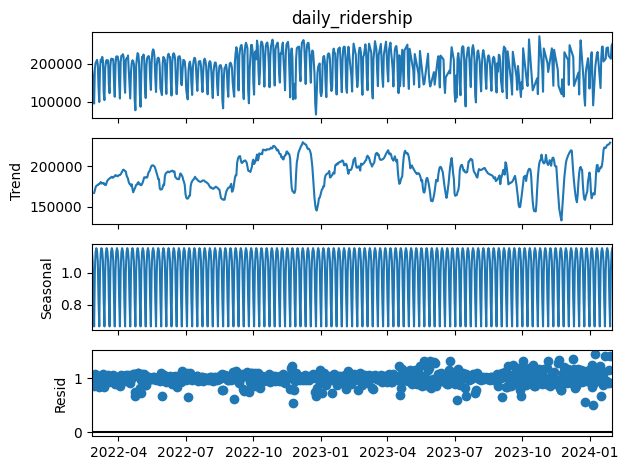

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition_plot_multi = seasonal_decompose(daily_df['daily_ridership'],
                                              model='multiplicative',
                                              period = 7)
decomposition_plot_multi.plot()
plt.show()

### Additive Decomposition

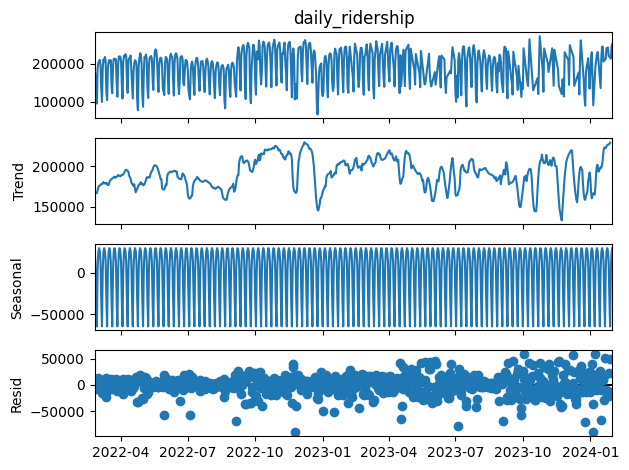

In [45]:
decomposition_plot_add = seasonal_decompose(daily_df["daily_ridership"],
                                            model = 'additive',
                                            period= 7)
decomposition_plot_add.plot()
plt.show()

## Autocorrelation

Checking the correaltion of time series data with the lagged version of the same data to figure out seasonality

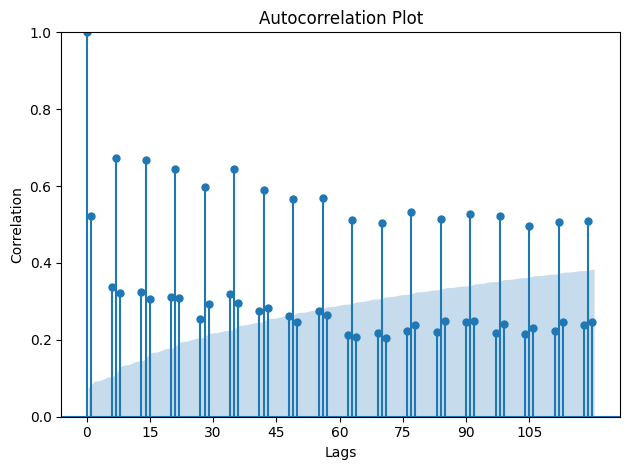

In [46]:
def acf(df,col,lags):
    plot_acf(df[col], lags = lags)
    plt.ylim(0,1)
    plt.xlabel('Lags')
    plt.xticks(ticks=np.arange(0,lags,15))
    plt.ylabel('Correlation')
    plt.title('Autocorrelation Plot')
    plt.tight_layout()
    plt.show()
acf(daily_df,col = 'daily_ridership',lags = 120)

## Partial Autocorrelation

Partial autocorrelation is the correlation of time series at two different lags ignoring the intermediate lags. ACF is more useful as it helps in determining seasonality, trends( if it needs differencing). PACF can help us determine auto regressive components

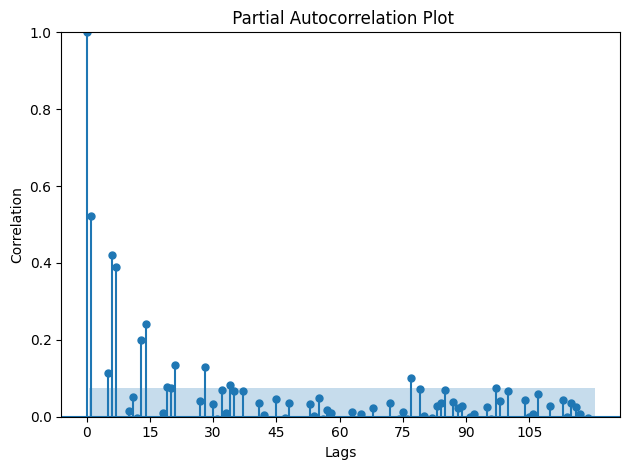

In [47]:
def pacf(df,col,lags):
    plot_pacf(df[col], lags = lags)
    plt.ylim(0,1)
    plt.xlabel('Lags')
    plt.xticks(ticks=np.arange(0,lags,15))
    plt.ylabel('Correlation')
    plt.title(' Partial Autocorrelation Plot')
    plt.tight_layout()
    plt.show()
pacf(daily_df,col='daily_ridership',lags=120)

## Forecasting Techniques
In this section, I will be experimenting with Holts-Winter Model, ARIMA and SARIMA, to see which fits the best

In [48]:
def plot_func(df,forecast, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index , y = df['daily_ridership'], name = 'Training Data'))
    fig.add_trace(go.Scatter(x = daily_df_test.index, y = daily_df_test['daily_ridership'], name = 'Test Data'))
    fig.add_trace(go.Scatter(x = daily_df_test.index, y = forecast, name='Forecast'))
    fig.update_layout(hovermode = "x unified")
    #fig.update_layout(font=dict(size=18), title_text=title,
                     # title_x=0.5,  xaxis_title='Date',
                      #yaxis_title='Mean Ridership')
    return fig.show()

In [49]:
def error(forecast):
    mae = mean_absolute_error(daily_df_test["daily_ridership"], forecast)
    print(mae)

In [50]:
one_train_df = daily_df.copy()
# There will be nulls because of differencing
daily_df = daily_df.dropna(subset=["daily_ridership_diff", "daily_ridership_box_cox_diff"])

### Finding Lags
Let us plot the partial autocorrelation to find out the lag. It seems to be 190 lags !! but more significant around 60. Another way of doing it is to iterate over all lags and select the best. This might be computationally expensive.

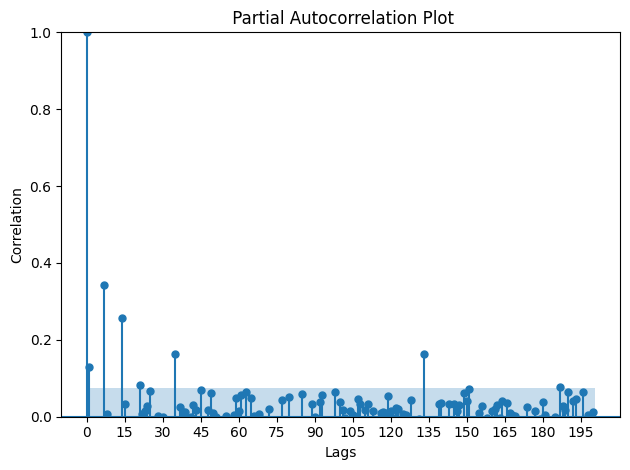

In [51]:
pacf(daily_df,col = 'daily_ridership_box_cox_diff',lags=200)

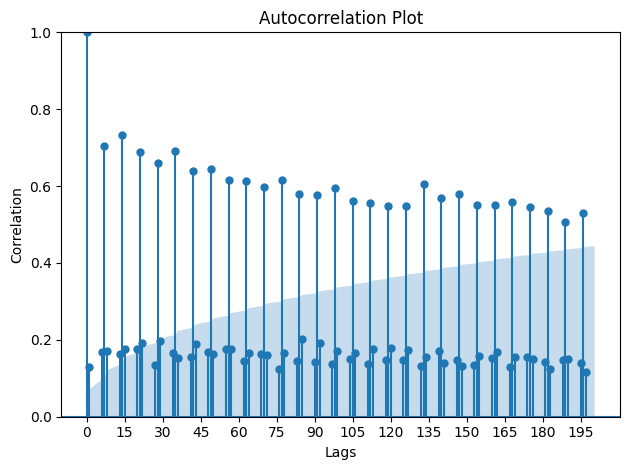

In [52]:
acf(daily_df,'daily_ridership_box_cox_diff',200)

In [53]:
selector = ar_select_order(daily_df["daily_ridership_box_cox_diff"],140)
print(selector.ar_lags)
model_auto_reg = AutoReg(daily_df["daily_ridership_box_cox_diff"], lags=selector.ar_lags).fit()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


### Holt Winters Model

In [54]:
model_holt_winters = ExponentialSmoothing(daily_df['daily_ridership'], trend='mul', seasonal='mul',seasonal_periods=114).fit(optimized = True)
forecast_holt_winters = model_holt_winters.forecast(len(daily_df_test))
plot_func(daily_df,forecast_holt_winters, 'Holt Winters Model')

In [55]:
model_holt_winters.summary()

Dep. Variable:,daily_ridership,No. Observations:,706
Model:,ExponentialSmoothing,SSE,1270066214218.782
Optimized:,True,AIC,15281.195
Trend:,Multiplicative,BIC,15819.230
Seasonal:,Multiplicative,AICC,15330.836
Seasonal Periods:,114,Date:,"Sun, 04 May 2025"
Box-Cox:,False,Time:,23:13:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0757143,alpha,True
smoothing_trend,0.0001,beta,True


In [56]:
error(forecast_holt_winters)

20968.410932011302


### ARIMA

In [57]:
p=14 # the Autoregressive Component through pacf or ar.selector
d=1 # the differencing componenet to make the dat stationary
q=60 # The Moving Average Component thorugh acf
model_arima= ARIMA(one_train_df['daily_ridership_box_cox'],order=(p,d,q)).fit()
boxcox_forecasts = model_arima.forecast(len(daily_df_test))
forecast_arima = inv_boxcox(boxcox_forecasts, lam)
plot_func(one_train_df,forecast_arima, title="ARIMA Model")

In [58]:
error(forecast_arima)

26709.485501451698


### SARIMA

In [59]:
model_sarima = ARIMA(one_train_df["daily_ridership_box_cox"], order=(30,1,14), seasonal_order=(0,1,0,7)).fit()
boxcox_forecasts = model_sarima.forecast(len(daily_df_test))
forecast_sarima = inv_boxcox(boxcox_forecasts, lam)
plot_func(one_train_df,forecast_sarima, title="ARIMA Model")

In [60]:

error(forecast_sarima)

13305.188023255529


## Residual Analysis

We can use the residuals to analyse how our model fits our assumptions. the difference between errors and residual is the how the fitted value (i.e. the value generated from the model we are using) on the train set differs from the actual value while the difference in the error values is how the predicted values differ from the test values. 

Error = predicted_values - actual_test_values
Residuals = fitted_values - actual_train_values

1. Residuals should have no autocorrelation or partial-auto correlation otherwise the model has missed the correct fit
2. Residuals should have mean 0 otherwise is biased


#### Ljung-Box Test

Null Hypothesis : Residuals are independently distributed
Alternate Hypthesis : Residuals are not independently distributed and exhibit serial correlation

In [61]:
def model_eval(model):
    residual_df = daily_df.copy()
    residual_df['fitted_values'] = model.fittedvalues
    residual_df["residuals"] = model.resid
    print(f'The mean of the residuals of {model} is {residual_df["residuals"].mean()}')
    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    plot_acf(residual_df['residuals'], lags = 60, ax = ax[0])
    ax[0].set_xlabel('Lags')
    plot_pacf(residual_df['residuals'], lags=60, ax=ax[1])
    ax[1].set_xlabel('Lags')
    plt.tight_layout()
    plt.show()
    print(f"Ljungbox Test: \n{acorr_ljungbox(residual_df['residuals'], return_df=True)}")
    print(f"Mean of residuals: {residual_df['residuals'].mean()}")

### Residual Analysis for Holt-Winters Model

The mean of the residuals of <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0xa17de8910> is -1410.5321094759236


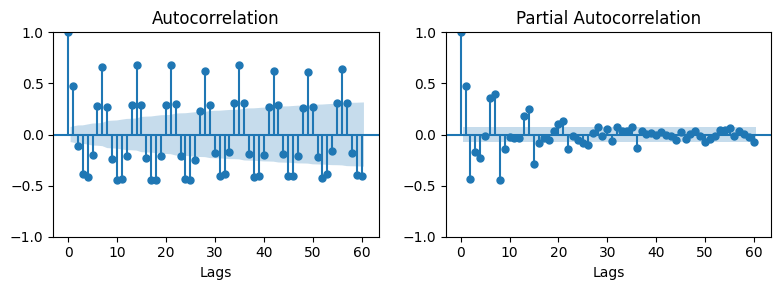

Ljungbox Test: 
        lb_stat      lb_pvalue
1    161.050801   6.669073e-37
2    169.660140   1.441348e-37
3    276.511451   1.204093e-59
4    401.025667   1.669881e-85
5    430.214675   9.087446e-91
6    487.283588  4.610541e-102
7    798.206835  4.523219e-168
8    851.120783  1.964571e-178
9    891.259155  4.728409e-186
10  1036.262814  2.879365e-216
Mean of residuals: -1410.5321094759236


In [62]:
model_eval(model_holt_winters)

### Residual Analysis for ARIMA

The mean of the residuals of <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0xa179cefb0> is 96797281.46421792


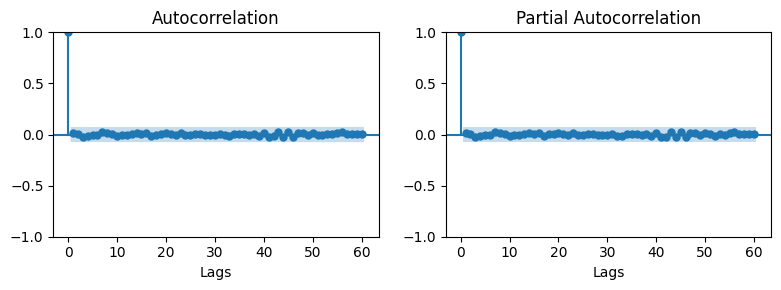

Ljungbox Test: 
     lb_stat  lb_pvalue
1   0.081037   0.775897
2   0.091382   0.955337
3   0.575546   0.902007
4   0.701768   0.951111
5   0.701840   0.982868
6   0.701889   0.994450
7   1.227934   0.990269
8   1.396559   0.994295
9   1.451704   0.997489
10  1.605775   0.998566
Mean of residuals: 96797281.46421792


In [63]:
model_eval(model_arima)

### Residual Analysis for SARIMA

The mean of the residuals of <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0xa17d8d540> is -151937102.596398


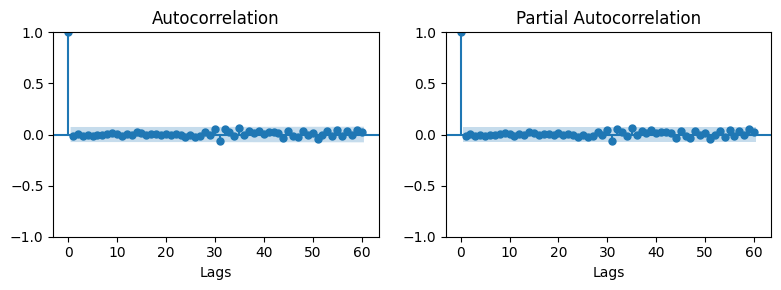

Ljungbox Test: 
     lb_stat  lb_pvalue
1   0.100540   0.751183
2   0.105742   0.948502
3   0.221455   0.974054
4   0.275737   0.991326
5   0.380382   0.995853
6   0.404364   0.998815
7   0.405277   0.999725
8   0.457996   0.999905
9   0.671764   0.999893
10  0.700902   0.999967
Mean of residuals: -151937102.596398


In [64]:
model_eval(model_sarima)

For this data SARIMA seems to be working best. A few other methods that I did not try but would recommend for time series analysis are : TBATS, LSTMS and Fourier Series and Harmonic Regression.